In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [4]:
df = pd.read_csv("/Users/zafiraibraeva/Code/uni coding/thesis/thesis_code/thesis/webapp/dataset/final_data.csv")

print("Dataset Info:")
df.info()

df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         4018 non-null   int64  
 1   Station1_CO        4018 non-null   float64
 2   Station1_NO2       4018 non-null   float64
 3   Station1_NOx       4018 non-null   float64
 4   Station1_PM10      4018 non-null   float64
 5   Station1_SO2       4018 non-null   float64
 6   Station2_CO        4018 non-null   float64
 7   Station2_NO2       4018 non-null   float64
 8   Station2_NOx       4018 non-null   float64
 9   Station2_O3        4018 non-null   float64
 10  Station2_PM10      4018 non-null   float64
 11  Station2_SO2       4018 non-null   float64
 12  temp               4018 non-null   float64
 13  humidity           4018 non-null   float64
 14  precip             4018 non-null   float64
 15  precipcover        4018 non-null   float64
 16  cloudcover

,Unnamed: 0,Station1_CO,Station1_NO2,Station1_NOx,Station1_PM10,Station1_SO2,Station2_CO,Station2_NO2,Station2_NOx,Station2_O3,...,windspeed,visibility,is_heating_season,is_work_day,winddir_sin,winddir_cos,Date,year,month,day
0,0,1057.0,31.3,67.6,56.0,6.96,1121.0,19.9,27.5,9.3,...,7.3,2.6,1,1,0.979223,-0.202787,2014-01-01,2014,1,1
1,1,1030.0,37.0,89.1,60.0,11.12,1212.0,25.9,44.4,9.9,...,10.9,6.4,1,1,0.685818,-0.727773,2014-01-02,2014,1,2
2,2,1319.0,49.1,196.1,69.0,10.18,1292.0,26.3,60.5,7.5,...,14.3,11.0,1,1,0.068015,-0.997684,2014-01-03,2014,1,3
3,3,1001.0,36.9,94.8,46.0,11.66,952.0,21.6,27.3,7.6,...,17.9,8.0,1,0,0.432086,-0.901833,2014-01-04,2014,1,4
4,4,1155.0,37.3,102.6,39.0,9.32,1001.0,23.4,36.6,12.5,...,21.4,18.0,1,0,0.436802,-0.899558,2014-01-05,2014,1,5


In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
features = [
    "Station1_CO", "Station1_NO2", "Station1_NOx",
    "Station2_CO", "Station2_NO2", "Station2_NOx", "Station2_O3",
    "Station1_SO2", "Station2_SO2",
    "Station1_PM10", "temp", "humidity", "precip",
    "precipcover", "cloudcover", "windspeed", "visibility",
    "winddir_sin", "winddir_cos", "is_heating_season", "is_work_day",
    "year", "month", "day"
]
target = "Station2_PM10"

print("\nMissing values:")
print(df[features + [target]].isnull().sum())


Missing values:
Station1_CO          0
Station1_NO2         0
Station1_NOx         0
Station2_CO          0
Station2_NO2         0
Station2_NOx         0
Station2_O3          0
Station1_SO2         0
Station2_SO2         0
Station1_PM10        0
temp                 0
humidity             0
precip               0
precipcover          0
cloudcover           0
windspeed            0
visibility           0
winddir_sin          0
winddir_cos          0
is_heating_season    0
is_work_day          0
year                 0
month                0
day                  0
Station2_PM10        0
dtype: int64


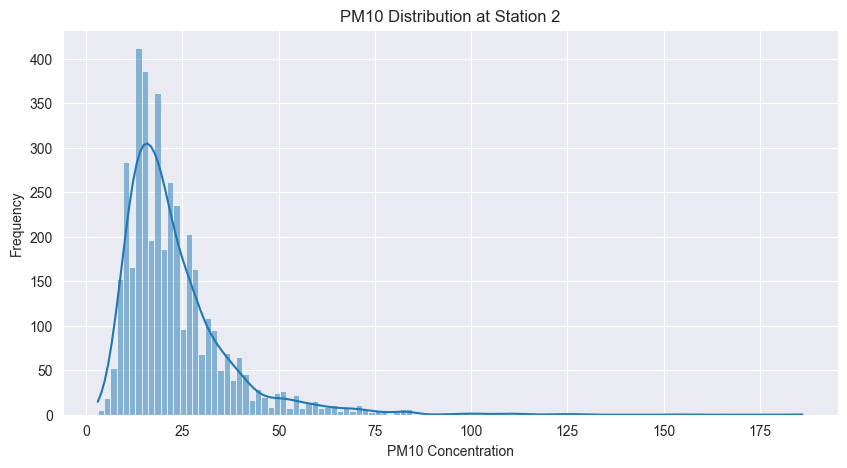

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(df[target], kde=True)
plt.title('PM10 Distribution at Station 2')
plt.xlabel('PM10 Concentration')
plt.ylabel('Frequency')
plt.show()

In [8]:
X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def create_sequences(data, targets, time_steps=30):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(data)):
        X_seq.append(data[i - time_steps:i, :])
        y_seq.append(targets[i])
    return np.array(X_seq), np.array(y_seq)

time_steps = 30
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")
print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")

Training data shape: (3214, 24)
Test data shape: (804, 24)
Training sequences shape: (3184, 30, 24)
Test sequences shape: (774, 30, 24)


In [9]:
print("Training GBDT model...")
gbdt = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    min_samples_split=5,
    random_state=42,
    verbose=1
)
gbdt.fit(X_train_scaled, y_train)

Training GBDT model...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         190.5763          20.1454            4.68s
         2         181.6350          52.9451            4.42s
         3         161.1696          -1.1185            4.28s
         4         148.8448          23.6345            4.20s
         5         142.0878          39.4682            4.18s
         6         127.2373           0.1096            4.16s
         7         111.7513          -7.1005            4.14s
         8         103.2600          16.0545            4.12s
         9          93.3739           5.2878            4.09s
        10          89.0790          23.6882            4.10s
        20          39.7728          -1.4839            3.96s
        30          20.0976           2.0849            3.82s
        40          12.3369           0.4890            3.67s
        50           8.9704           1.4790            3.52s
        60           7.1174           1.6933  

GradientBoostingRegressor(learning_rate=0.05, max_depth=6, min_samples_split=5,
                          n_estimators=300, random_state=42, subsample=0.8,
                          verbose=1)


GBDT Performance:
MSE: 25.0544
MAE: 3.2344
R2: 0.7740


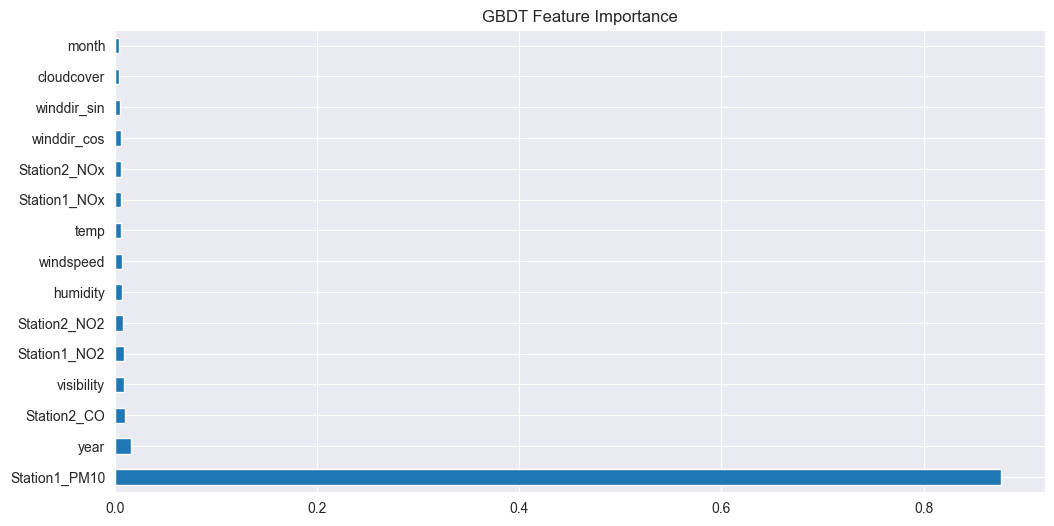

In [10]:
gbdt_pred = gbdt.predict(X_test_scaled)
gbdt_mse = mean_squared_error(y_test, gbdt_pred)
gbdt_mae = mean_absolute_error(y_test, gbdt_pred)
gbdt_r2 = r2_score(y_test, gbdt_pred)

print(f"\nGBDT Performance:")
print(f"MSE: {gbdt_mse:.4f}")
print(f"MAE: {gbdt_mae:.4f}")
print(f"R2: {gbdt_r2:.4f}")

plt.figure(figsize=(12, 6))
feat_importances = pd.Series(gbdt.feature_importances_, index=features)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('GBDT Feature Importance')
plt.show()

In [11]:
print("Training DART model...")
dart = LGBMRegressor(
    boosting_type='dart',
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    drop_rate=0.1,
    random_state=42,
    verbose=-1
)
dart.fit(X_train_scaled, y_train)

Training DART model...


LGBMRegressor(boosting_type='dart', colsample_bytree=0.8, drop_rate=0.1,
              learning_rate=0.05, max_depth=5, n_estimators=300,
              random_state=42, subsample=0.8, verbose=-1)


DART Performance:
MSE: 29.0275
MAE: 3.4249
R2: 0.7381


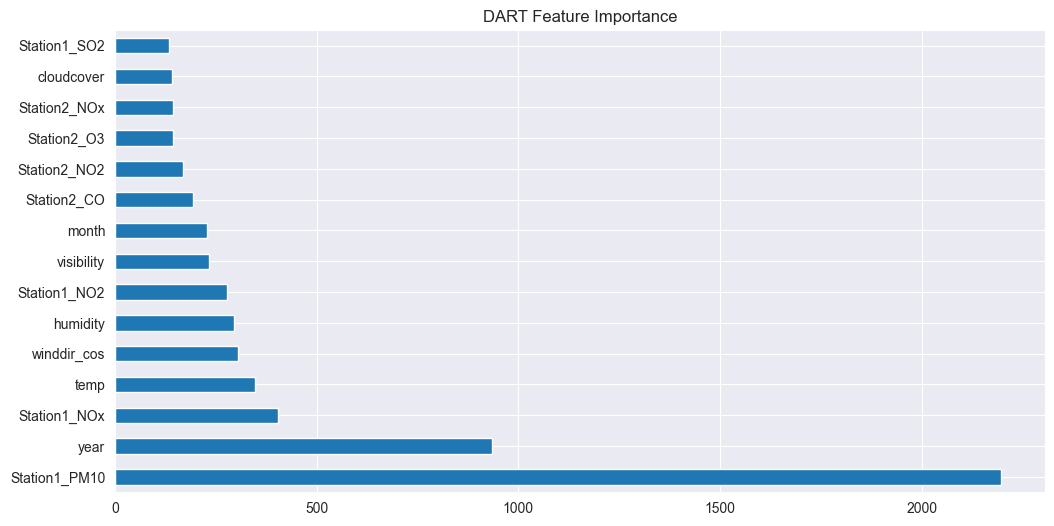

In [12]:
dart_pred = dart.predict(X_test_scaled)
dart_mse = mean_squared_error(y_test, dart_pred)
dart_mae = mean_absolute_error(y_test, dart_pred)
dart_r2 = r2_score(y_test, dart_pred)

print(f"\nDART Performance:")
print(f"MSE: {dart_mse:.4f}")
print(f"MAE: {dart_mae:.4f}")
print(f"R2: {dart_r2:.4f}")

plt.figure(figsize=(12, 6))
feat_importances = pd.Series(dart.feature_importances_, index=features)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('DART Feature Importance')
plt.show()

In [13]:
print("Training LightGBM model...")
lgbm = LGBMRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)
lgbm.fit(X_train_scaled, y_train)

Training LightGBM model...


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=5,
              n_estimators=300, random_state=42, subsample=0.8, verbose=-1)


LightGBM Performance:
MSE: 23.9965
MAE: 3.0982
R2: 0.7835


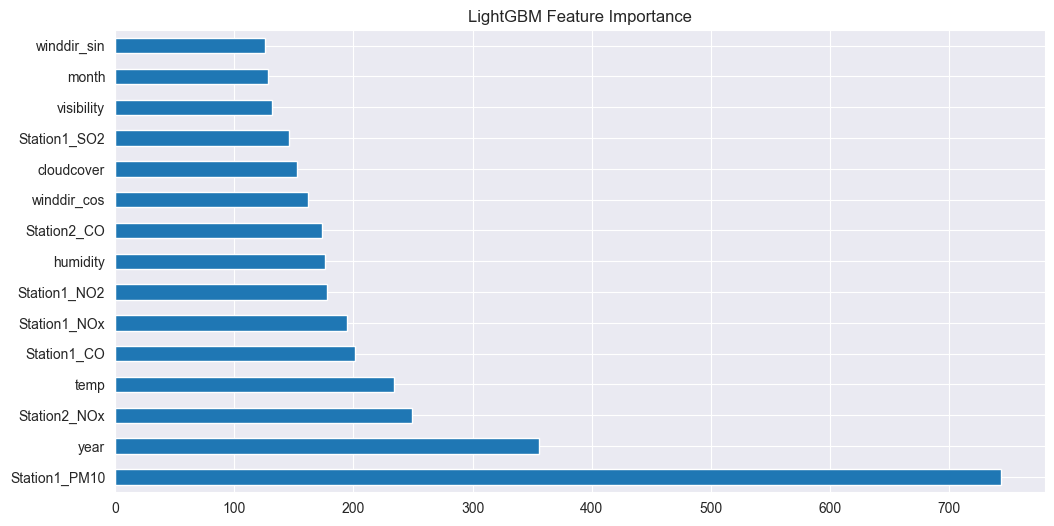

In [14]:
lgbm_pred = lgbm.predict(X_test_scaled)
lgbm_mse = mean_squared_error(y_test, lgbm_pred)
lgbm_mae = mean_absolute_error(y_test, lgbm_pred)
lgbm_r2 = r2_score(y_test, lgbm_pred)

print(f"\nLightGBM Performance:")
print(f"MSE: {lgbm_mse:.4f}")
print(f"MAE: {lgbm_mae:.4f}")
print(f"R2: {lgbm_r2:.4f}")

plt.figure(figsize=(12, 6))
feat_importances = pd.Series(lgbm.feature_importances_, index=features)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('LightGBM Feature Importance')
plt.show()

In [15]:
lstm_model = Sequential([
    LSTM(512, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.3),
    LSTM(256),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='mse',
                   metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Training LSTM model...")
lstm_history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Training LSTM model...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 528.9684 - mae: 17.6598 - val_loss: 131.1337 - val_mae: 9.0485
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 216.7634 - mae: 9.9995 - val_loss: 126.0615 - val_mae: 8.8923
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 225.2495 - mae: 9.9076 - val_loss: 121.9798 - val_mae: 8.8656
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 212.3978 - mae: 9.9009 - val_loss: 96.8351 - val_mae: 7.8719
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 222.3132 - mae: 9.8001 - val_loss: 87.4693 - val_mae: 7.5016
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 187.1599 - mae: 9.3237 - val_loss: 77.4287 - val_mae: 6.8393
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 190.8092 - mae: 9.2658 - val_loss: 73.4191 - val_mae: 6.7264
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 141.7904 - mae: 8.0686 - val_loss: 93.8583 - val_mae: 7.54

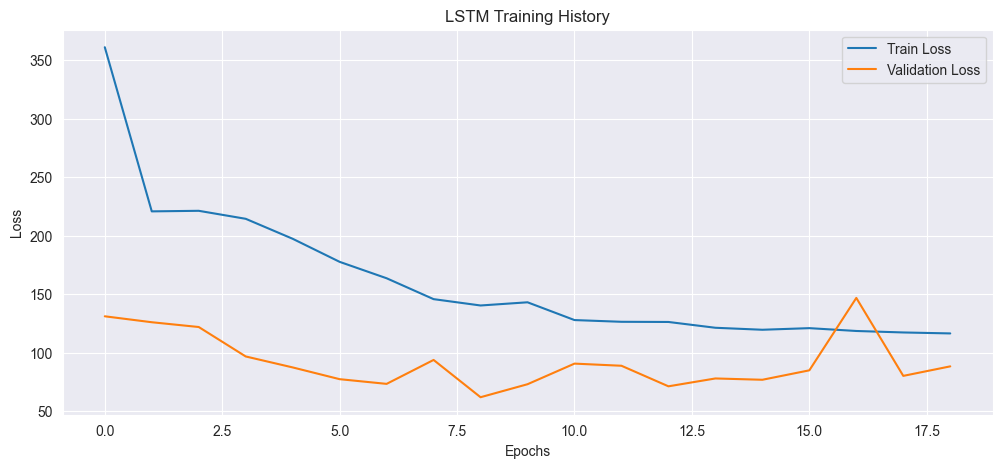

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

LSTM Performance:
MSE: 79.9084
MAE: 6.2388
R2: 0.2927


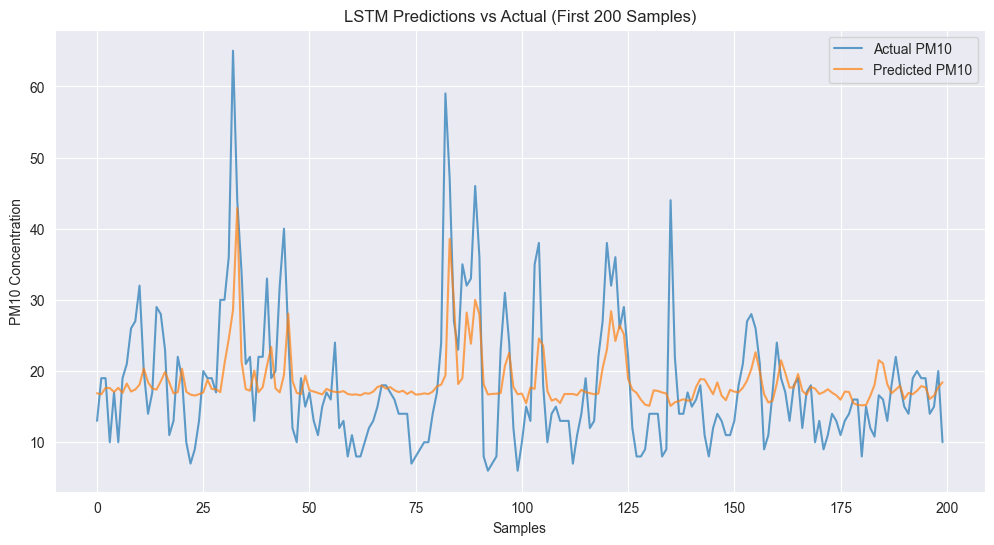

In [17]:
lstm_pred = lstm_model.predict(X_test_seq).flatten()
lstm_mse = mean_squared_error(y_test_seq, lstm_pred)
lstm_mae = mean_absolute_error(y_test_seq, lstm_pred)
lstm_r2 = r2_score(y_test_seq, lstm_pred)

print(f"\nLSTM Performance:")
print(f"MSE: {lstm_mse:.4f}")
print(f"MAE: {lstm_mae:.4f}")
print(f"R2: {lstm_r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_seq[:200], label='Actual PM10', alpha=0.7)
plt.plot(lstm_pred[:200], label='Predicted PM10', alpha=0.7)
plt.title('LSTM Predictions vs Actual (First 200 Samples)')
plt.xlabel('Samples')
plt.ylabel('PM10 Concentration')
plt.legend()
plt.show()

In [18]:
gru_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.3),
    GRU(64),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])

print("Training GRU model...")
gru_history = gru_model.fit(
    X_train_seq, y_train_seq,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Training GRU model...
Epoch 1/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 825.3661 - mae: 23.9166 - val_loss: 203.2468 - val_mae: 10.5797
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 302.2791 - mae: 11.7015 - val_loss: 113.2863 - val_mae: 8.2643
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 206.7807 - mae: 9.8699 - val_loss: 114.4843 - val_mae: 8.2217
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 221.4223 - mae: 10.2848 - val_loss: 119.9359 - val_mae: 8.2611
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 204.5110 - mae: 9.6377 - val_loss: 105.6341 - val_mae: 7.7918
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 159.1299 - mae: 8.7279 - val_loss: 100.5200 - val_mae: 7.5229
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 185.0993 - mae: 9.0773 - val_loss: 81.0387 - val_mae: 6.8861
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 146.2907 - mae: 8.0849 - val_loss: 66.9816 - val_mae: 6.1225


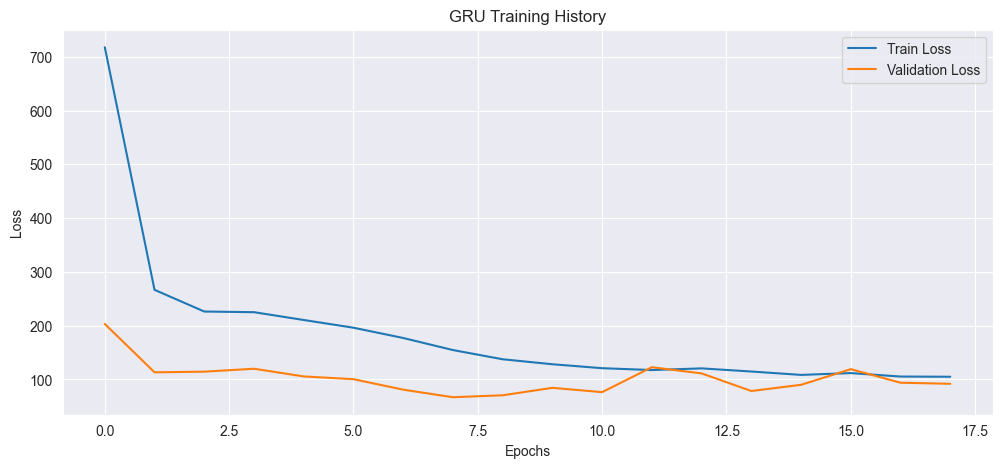

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

GRU Performance:
MSE: 74.7676
MAE: 6.3511
R2: 0.3382


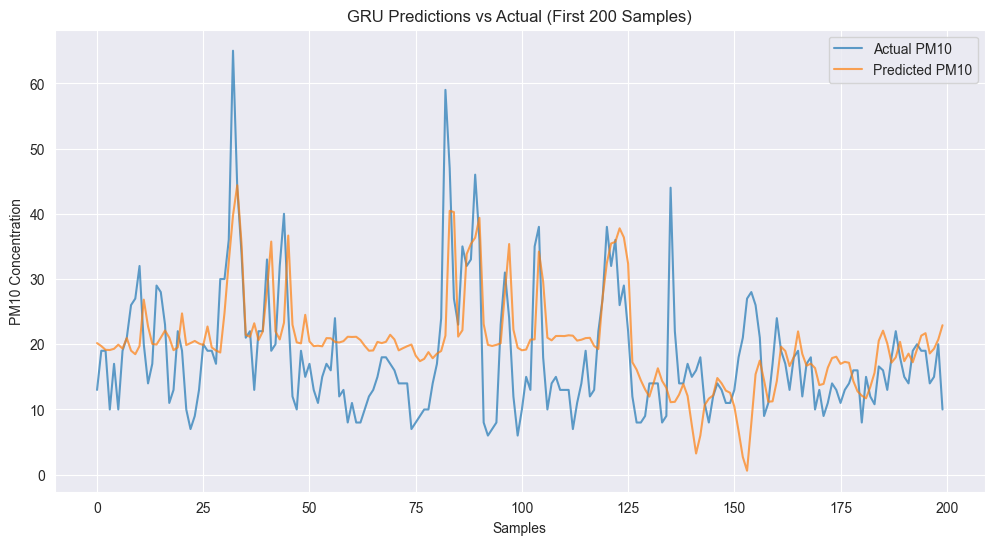

In [20]:
gru_pred = gru_model.predict(X_test_seq).flatten()
gru_mse = mean_squared_error(y_test_seq, gru_pred)
gru_mae = mean_absolute_error(y_test_seq, gru_pred)
gru_r2 = r2_score(y_test_seq, gru_pred)

print(f"\nGRU Performance:")
print(f"MSE: {gru_mse:.4f}")
print(f"MAE: {gru_mae:.4f}")
print(f"R2: {gru_r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_seq[:200], label='Actual PM10', alpha=0.7)
plt.plot(gru_pred[:200], label='Predicted PM10', alpha=0.7)
plt.title('GRU Predictions vs Actual (First 200 Samples)')
plt.xlabel('Samples')
plt.ylabel('PM10 Concentration')
plt.legend()
plt.show()

In [21]:
def get_meta_features(X_tree, X_seq, models):
    tree_preds = {
        'gbdt': models['gbdt'].predict(X_tree),
        'dart': models['dart'].predict(X_tree),
        'lgbm': models['lgbm'].predict(X_tree)
    }

    seq_preds = {
        'lstm': models['lstm'].predict(X_seq).flatten(),
        'gru': models['gru'].predict(X_seq).flatten()
    }

    # Align predictions
    min_len = min(len(p) for p in [*tree_preds.values(), *seq_preds.values()])

    meta_X = np.column_stack([
        tree_preds['gbdt'][-min_len:],
        tree_preds['dart'][-min_len:],
        tree_preds['lgbm'][-min_len:],
        seq_preds['lstm'][-min_len:],
        seq_preds['gru'][-min_len:]
    ])

    return meta_X

In [22]:
meta_X_train = get_meta_features(X_train_scaled[time_steps:], X_train_seq,
                                 {'gbdt': gbdt, 'dart': dart, 'lgbm': lgbm,
                                  'lstm': lstm_model, 'gru': gru_model})
meta_y_train = y_train[time_steps:len(X_train_scaled[time_steps:]) + time_steps]

meta_X_test = get_meta_features(X_test_scaled[time_steps:], X_test_seq,
                                {'gbdt': gbdt, 'dart': dart, 'lgbm': lgbm,
                                 'lstm': lstm_model, 'gru': gru_model})
meta_y_test = y_test[time_steps:len(X_test_scaled[time_steps:]) + time_steps]

print(f"Meta-features training shape: {meta_X_train.shape}")
print(f"Meta-features test shape: {meta_X_test.shape}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Meta-features training shape: (3184, 5)
Meta-features test shape: (774, 5)


In [23]:
meta_model = Sequential([
    Dense(64, activation='relu', input_dim=meta_X_train.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

meta_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='mse')

print("Training meta-model...")
meta_history = meta_model.fit(
    meta_X_train, meta_y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Training meta-model...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 759.1591 - val_loss: 19.4569
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 50.1947 - val_loss: 5.6898
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 32.4203 - val_loss: 4.6299
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 27.3136 - val_loss: 5.3295
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 25.3391 - val_loss: 4.6716
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 25.7758 - val_loss: 7.3766
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 29.7933 - val_loss: 6.1053
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 17.8322 - val_loss: 8.3651
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 19.6588 - val_loss: 5.2957
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 16.9074 - val_loss: 6.6185
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 18.5283 - val_loss: 6.6696
Epoch 1

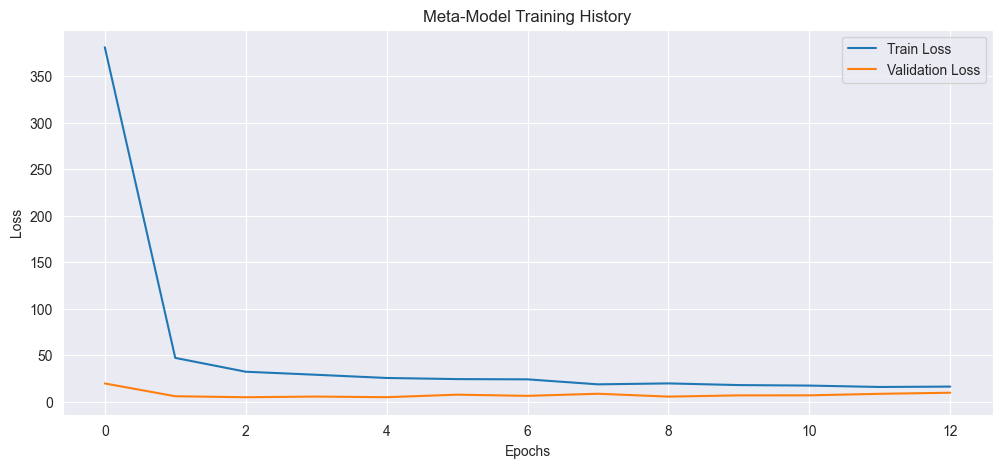

In [24]:
plt.figure(figsize=(12, 5))
plt.plot(meta_history.history['loss'], label='Train Loss')
plt.plot(meta_history.history['val_loss'], label='Validation Loss')
plt.title('Meta-Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
base_results = {
    'GBDT': {'mse': gbdt_mse, 'mae': gbdt_mae, 'r2': gbdt_r2},
    'DART': {'mse': dart_mse, 'mae': dart_mae, 'r2': dart_r2},
    'LightGBM': {'mse': lgbm_mse, 'mae': lgbm_mae, 'r2': lgbm_r2},
    'LSTM': {'mse': lstm_mse, 'mae': lstm_mae, 'r2': lstm_r2},
    'GRU': {'mse': gru_mse, 'mae': gru_mae, 'r2': gru_r2}
}

print("Base Model Performance:")
display(pd.DataFrame(base_results).T)

Base Model Performance:


,mse,mae,r2
GBDT,25.054411,3.234387,0.773976
DART,29.027509,3.424899,0.738133
LightGBM,23.996549,3.098153,0.783519
LSTM,79.908360,6.238850,0.292675
GRU,74.767588,6.351124,0.338180


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step

Ensemble Model Performance:
MSE: 26.5826
MAE: 3.3774
R2: 0.7647


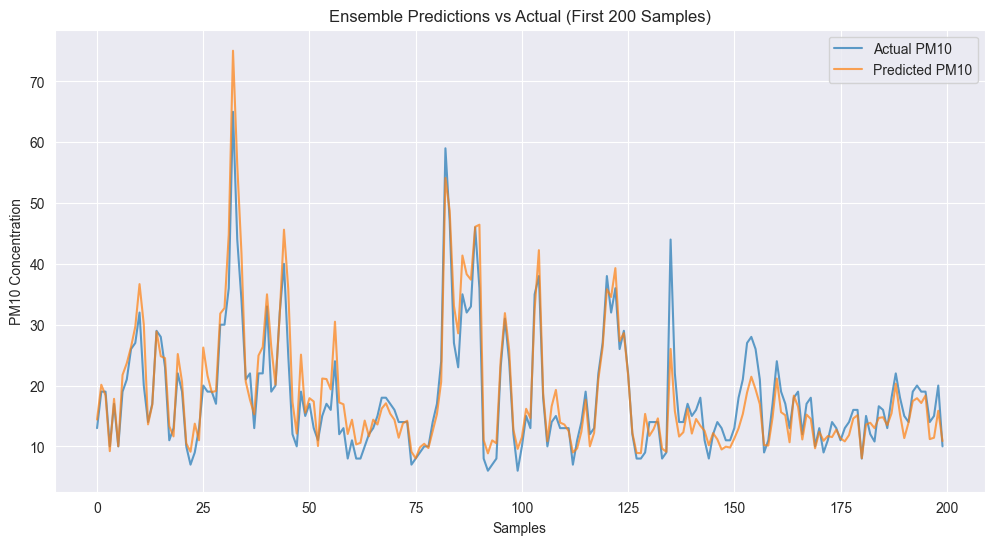

In [26]:
ensemble_pred = meta_model.predict(meta_X_test).flatten()
ensemble_mse = mean_squared_error(meta_y_test, ensemble_pred)
ensemble_mae = mean_absolute_error(meta_y_test, ensemble_pred)
ensemble_r2 = r2_score(meta_y_test, ensemble_pred)

print("\nEnsemble Model Performance:")
print(f"MSE: {ensemble_mse:.4f}")
print(f"MAE: {ensemble_mae:.4f}")
print(f"R2: {ensemble_r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(meta_y_test[:200], label='Actual PM10', alpha=0.7)
plt.plot(ensemble_pred[:200], label='Predicted PM10', alpha=0.7)
plt.title('Ensemble Predictions vs Actual (First 200 Samples)')
plt.xlabel('Samples')
plt.ylabel('PM10 Concentration')
plt.legend()
plt.show()

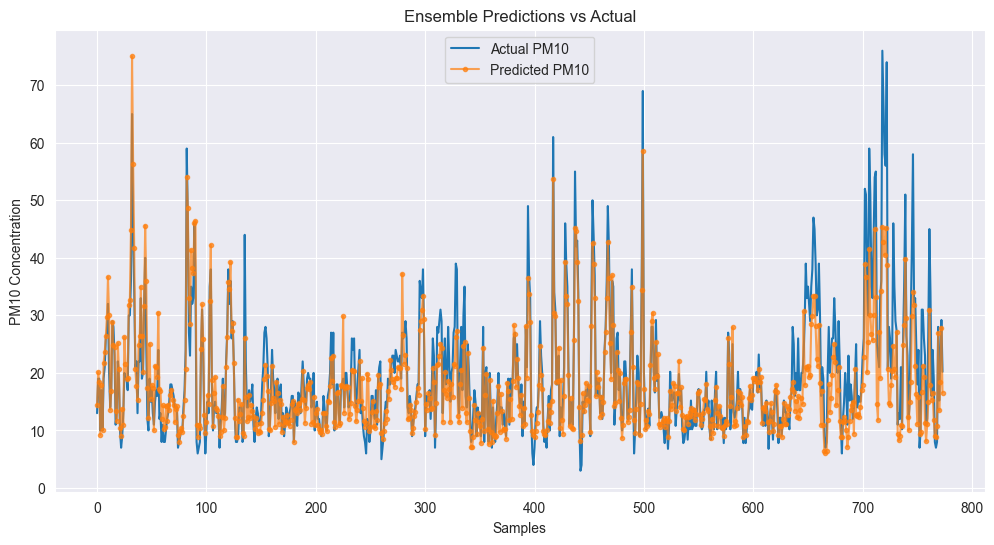

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(meta_y_test, label='Actual PM10')
plt.plot(ensemble_pred, label='Predicted PM10', alpha=0.7, marker='.')
plt.title('Ensemble Predictions vs Actual')
plt.xlabel('Samples')
plt.ylabel('PM10 Concentration')
plt.legend()
plt.show()

In [28]:
meta_model.compile(optimizer='adam', loss='mse')  # ensure compiled
meta_model.save('ensemble_model.keras', include_optimizer=True)  # save with optimizer and loss
